### Data Augmentation 

Helps to increase the diversity of out training data without actually collecting new data.

c:\Users\vales\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5859 - loss: 0.6615 - val_accuracy: 0.7355 - val_loss: 0.5342
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.7489 - loss: 0.5154 - val_accuracy: 0.7627 - val_loss: 0.4944
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.7839 - loss: 0.4527 - val_accuracy: 0.7816 - val_loss: 0.4717
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8047 - loss: 0.4176 - val_accuracy: 0.8044 - val_loss: 0.4341
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8307 - loss: 0.3709 - val_accuracy: 0.8144 - val_loss: 0.4355
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8590 - loss: 0.3225 - val_accuracy: 0.7996 - val_loss: 0.4342
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8785 - loss: 0.2798 - val_accuracy: 0.8056 - val_loss: 0.4668
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9050 - loss: 0.2317 - 

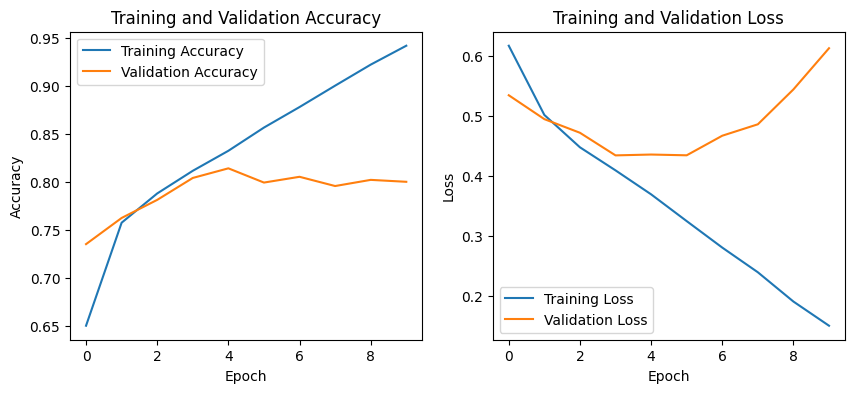

In [8]:
import os
import cv2
import numpy as np
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
DATADIR = r'C:\Users\vales\OneDrive\Escritorio\kagglecatsanddogs_5340 (1)\PetImages'
CATEGORIES = ['Cat', 'Dog']
IMG_SIZE = 50
TRAINING_DATA_PATH = r'C:\Users\vales\OneDrive\Escritorio\training_data.pickle'
FILEPATH_X = r'C:\Users\vales\OneDrive\Escritorio\X.pickle'
FILEPATH_Y = r'C:\Users\vales\OneDrive\Escritorio\y.pickle'
MODEL_SAVE_PATH = r'C:\Users\vales\OneDrive\Escritorio\cat_dog_model.h5'

def load_and_preprocess_image(path):
    img_array = cv2.imread(path, cv2.IMREAD_COLOR) 
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array

def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = load_and_preprocess_image(os.path.join(path, img))
                training_data.append([img_array, class_num])
            except Exception as e:
                pass
    random.shuffle(training_data)
    return training_data

def save_training_data(training_data):
    with open(TRAINING_DATA_PATH, 'wb') as f:
        pickle.dump(training_data, f)

def load_training_data():
    with open(TRAINING_DATA_PATH, 'rb') as f:
        return pickle.load(f)

def prepare_data(training_data):
    X = []
    y = []
    for features, label in training_data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)  
    y = np.array(y)
    return X, y

def save_data(X, y, filepath_X, filepath_y):
    with open(filepath_X, 'wb') as f:
        pickle.dump(X, f)
    with open(filepath_y, 'wb') as f:
        pickle.dump(y, f)

def load_data(filepath_X, filepath_y):
    with open(filepath_X, 'rb') as f:
        X = pickle.load(f)
    with open(filepath_y, 'rb') as f:
        y = pickle.load(f)
    return X, y

def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation("relu"))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def main():
    training_data = create_training_data()
    save_training_data(training_data)
    training_data = load_training_data()

    X, y = prepare_data(training_data)
    save_data(X, y, FILEPATH_X, FILEPATH_Y)

    X, y = load_data(FILEPATH_X, FILEPATH_Y)
    X = X / 255.0  

    # Split data into training and validation sets
    validation_split = 0.1
    split_idx = int(len(X) * (1 - validation_split))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    model = build_model(X_train.shape[1:])

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


if __name__ == "__main__":
    main()


* The calidation accuracy and loss are fairly consistent with the training metrics, indicationg that the model is learning appropriatly withut overfitting
* Both training and validation loss curves stabilize towards the end, indicationg thta the model has reached a point of convergence.
* Overall, the graphd suggest that the mdeol in performig well, learning from the training data. There's no significant overfitting.

### L1/L2 Regularization

This helps prevent overfitting by penalizing large weights

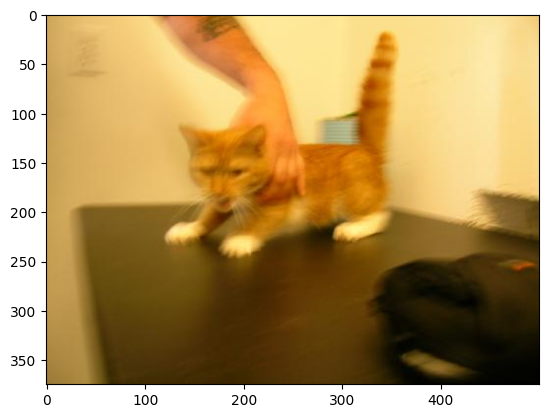

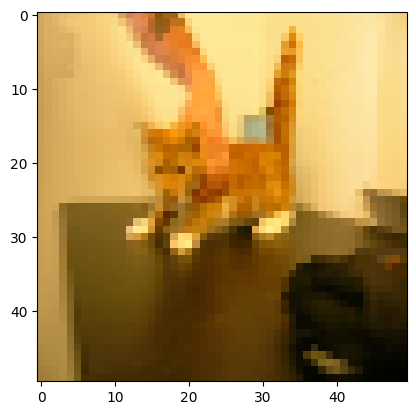

24946
1
0
1
0
1
0
1
0
1
0
Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6213 - loss: 0.7066 - val_accuracy: 0.7210 - val_loss: 0.5789
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.7398 - loss: 0.5607 - val_accuracy: 0.7535 - val_loss: 0.5414
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7767 - loss: 0.5208 - val_accuracy: 0.7631 - val_loss: 0.5227
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.7974 - loss: 0.4921 - val_accuracy: 0.7715 - val_loss: 0.5226
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.7970 - loss: 0.4924 - val_accuracy: 0.7543 - val_loss: 0.5545
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.8065 - loss: 0.4747 - val_accuracy: 0.7968 - val_loss: 0.5024
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8181 - loss: 0.4624 - val_accuracy: 0.8036 - val_loss: 0.4869
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy

In [12]:
from tensorflow.keras.regularizers import l2

# Define data directory and categories
DATADITR = r'C:\Users\vales\OneDrive\Escritorio\kagglecatsanddogs_5340 (1)\PetImages'
CATEGORIES = ['Cat', 'Dog']
IMG_SIZE = 50

# Display one image to check
for category in CATEGORIES:
    path = os.path.join(DATADITR, category)  # path to cats or dogs dir
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

# Resize one image to check
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

# Create training data
training_data = []

def creating_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADITR, category)  # path to cats or dogs dir
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

creating_training_data()
print(len(training_data))

# Shuffle the training data
random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

# Separate features and labels
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# Normalize the data
X = X / 255.0

# Save the data
filepath_X = 'C:/Users/vales/OneDrive/Escritorio/X.pickle'
filepath_y = 'C:/Users/vales/OneDrive/Escritorio/y.pickle'

with open(filepath_X, 'wb') as f:
    pickle.dump(X, f)

with open(filepath_y, 'wb') as f:
    pickle.dump(y, f)

# Load the data in another session/script
with open(filepath_X, 'rb') as f:
    X_loaded = pickle.load(f)

with open(filepath_y, 'rb') as f:
    y_loaded = pickle.load(f)

# Build the model with L2 regularization
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:], kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

In [11]:
from tensorflow.keras.regularizers import l2

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

X = X / 255.0

filepath_X = 'C:/Users/vales/OneDrive/Escritorio/X.pickle'
filepath_y = 'C:/Users/vales/OneDrive/Escritorio/y.pickle'

with open(filepath_X, 'wb') as f:
    pickle.dump(X, f)

with open(filepath_y, 'wb') as f:
    pickle.dump(y, f)

with open(filepath_X, 'rb') as f:
    X_loaded = pickle.load(f)

with open(filepath_y, 'rb') as f:
    y_loaded = pickle.load(f)

# Model with L2 regularization
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:], kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


NameError: name 'training_data' is not defined

### Adding a convolutional Layer

This additional layer can help the model lear more complex partterns by increasing its depth. A third convolutional layer with 64 filters, a kernel size of (3,3), ReLu activation and max pooling layer.

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.5688 - loss: 0.6690 - val_accuracy: 0.7327 - val_loss: 0.5305
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7428 - loss: 0.5198 - val_accuracy: 0.7743 - val_loss: 0.4684
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.7892 - loss: 0.4441 - val_accuracy: 0.7840 - val_loss: 0.4438
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8180 - loss: 0.3963 - val_accuracy: 0.7928 - val_loss: 0.4408
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8428 - loss: 0.3503 - val_accuracy: 0.8152 - val_loss: 0.4372
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8630 - loss: 0.3123 - val_accuracy: 0.8232 - val_loss: 0.3821
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8799 - loss: 0.2820 - val_accuracy: 0.8357 - val_loss: 0.3766
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8929 - loss: 0.2481 - 

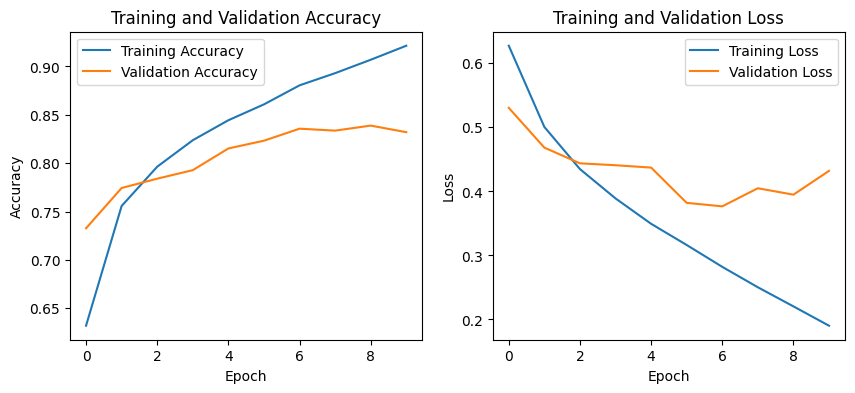

In [22]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

X = X / 255.0

filepath_X = 'C:/Users/vales/OneDrive/Escritorio/X.pickle'
filepath_y = 'C:/Users/vales/OneDrive/Escritorio/y.pickle'

with open(filepath_X, 'wb') as f:
    pickle.dump(X, f)

with open(filepath_y, 'wb') as f:
    pickle.dump(y, f)

# Load the data in another session/script
with open(filepath_X, 'rb') as f:
    X_loaded = pickle.load(f)

with open(filepath_y, 'rb') as f:
    y_loaded = pickle.load(f)

# Build the model with an additional layer
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding an additional convolutional and max pooling layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Combining L1/L2 regularization with and additional convolutional layer

* The additional convolutional layer enchances the model's capacity to learn complex features, wile L1/L2 regularization ensures these features are learned in a way that avoids overfitting.
* L2 regularization combined with additional layers can lead to a model where weights are more evenly distribuited.


In [5]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

X = X / 255.0

filepath_X = 'C:/Users/vales/OneDrive/Escritorio/X.pickle'
filepath_y = 'C:/Users/vales/OneDrive/Escritorio/y.pickle'

with open(filepath_X, 'wb') as f:
    pickle.dump(X, f)

with open(filepath_y, 'wb') as f:
    pickle.dump(y, f)

# Load the data in another session/script
with open(filepath_X, 'rb') as f:
    X_loaded = pickle.load(f)

with open(filepath_y, 'rb') as f:
    y_loaded = pickle.load(f)

# Build the model with an additional layer
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:], kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding an additional convolutional and max pooling layer
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'training_data' is not defined

In [3]:
# Make predictions
predictions = model.predict(X_loaded)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

# Get indices of successful cat predictions (assuming cat label is 0)
cat_success_indices = np.where((predicted_labels == 0) & (y_loaded == 0))[0]

# Get indices of successful dog predictions (assuming dog label is 1)
dog_success_indices = np.where((predicted_labels == 1) & (y_loaded == 1))[0]

# Select the first 3 successful cat predictions
if len(cat_success_indices) >= 3:
    cat_success_indices = cat_success_indices[:3]
else:
    print("Less than 3 successful cat predictions found.")

# Select the first 3 successful dog predictions
if len(dog_success_indices) >= 3:
    dog_success_indices = dog_success_indices[:3]
else:
    print("Less than 3 successful dog predictions found.")

# Plot the images
plt.figure(figsize=(12, 8))

for i, idx in enumerate(cat_success_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_loaded[idx])
    plt.title(f'Predicted: Cat\nActual: Cat')
    plt.axis('off')

for i, idx in enumerate(dog_success_indices):
    plt.subplot(2, 3, i+4)
    plt.imshow(X_loaded[idx])
    plt.title(f'Predicted: Dog\nActual: Dog')
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined